In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import math
import copy

import scipy
from scipy.optimize import curve_fit
from scipy import integrate

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression

from collections import Counter


# Section 1. Qunatification

Step 1. Predictive models for expected volumne of patient visits P(t)

Step 2. Quantification for observed volumne of patient visits O(t) 

Step 3. Measure of resilience and adapativity

Step 4. Utilization of [Step 1,2,3] to different states with differrent healthcare services and poulations

In [2]:
#####Predictive models
def moving_average(list_input,window):
    list_output=list(map(lambda i:np.mean(list_input[i:i+window]) if i<=window  else np.mean(list_input[i-window:i]), np.arange(len(list_input))  ))
   
    return list_output

def predictive_model(df,strx,stry,t_start,case):
    columns=[strx]
    df_temp=df[(df['time_step']<t_start)&(df['time_step']>0)] ##select period for training
    
    if case=='linear':
        X=np.array(df_temp[columns].values)
        Y=np.array(df_temp[stry].values)
        X_all=np.array(df[columns].values)
        linreg=LinearRegression().fit(X,Y) ##linear regression
        y_pred=linreg.predict(X_all)
        coef=linreg.coef_
        intercept=linreg.intercept_
        df['#ofrecord_predict']=y_pred

    if case=='polynomial':
        df_temp['time_step_squre']=df_temp['time_step']*df_temp['time_step']
        df['time_step_squre']=df['time_step']*df['time_step']
        X=np.array(df_temp[['time_step','time_step_squre']].values)
        Y=np.array(df_temp[stry].values)
        X_all=np.array(df[['time_step','time_step_squre']].values)
        linreg=LinearRegression().fit(X,Y) ##linear regression
        y_pred=linreg.predict(X_all)
        coef=linreg.coef_
        intercept=linreg.intercept_
        df['#ofrecord_predict']=y_pred
        
    if case=='expoential_smoothing':
        base=10
        df[stry]=np.log(df[stry]+1)/np.log(base)
        df_temp=df[df['time_step']<t_start] ##select period for training
        X=np.array(list(df_temp['time_step']))
        Y=np.array(list(df_temp[stry]))
        
        model=ExponentialSmoothing(Y,trend='mul',seasonal=None)
        fit1=model.fit()

        pred1=fit1.forecast(len(df)-t_start)  
        
        y_pred=np.power(base,list(df_temp[stry])+list(pred1))
        df[stry]=np.power(base,df[stry])

        
    if case=='expoential_smoothing_season':
        base=10
        df[stry]=np.log(df[stry]+1)/np.log(base)
        df_temp=df[df['time_step']<t_start] ##select period for training
        X=np.array(list(df_temp['time_step']))
        Y=np.array(list(df_temp[stry]))
        
        model1=ExponentialSmoothing(Y,trend='mul',seasonal="add",seasonal_periods=4)

        fit1=model1.fit()

        pred1=fit1.forecast(len(df)-t_start)  
        
        y_pred=np.power(base,list(df_temp[stry])+list(pred1))
        df[stry]=np.power(base,df[stry])
        
        df['#ofrecord_predict']=y_pred
         
    return df

In [15]:
from scipy.signal import find_peaks
from collections import defaultdict
from statsmodels.tsa.holtwinters import ExponentialSmoothing


def beta_family_equation(t,b,c,v):
    '''
    equation for beta_family_equation 
    :param t: array of time
    :param a: disruption magnitude (a is known)
    :param b: disruption rate
    :param c: recovery rate
    :param v: duration
    return: fitted patient visits

    '''
    return (math.pow((b+c),b+c)/(math.pow(b,b)*math.pow(c,c)))*np.power(t/v,b)*np.power(1-(t)/v,c)


def quantification_model(df_count, t_start,duration,t_disruption_dict):
    '''
    :df_count: dataframe of P(t),O(t)
    :t_start: month of disruption start
    :duration: end of dataset concern
    :t_disruption_dict: mutiple disruptions and their respective period
    return O'(t), df_para, resilience, adapativity
    '''
    output_para_t=[]
    
    df=copy.deepcopy(df_data)
    df=df[df['time_step']>=t_start]

 
    MOP_all=list([0]*len(df_data))
    

    for diruption_count, t_disruption in t_disruption_dict.items():
        df_x=df[df['time_step'].isin(t_disruption)]
        X=t_disruption-np.min(t_disruption)
        Y_gap=df_x['#gap_percent'].values
        if Y_gap[-1]<=0.05:
            recovered=1
        else:
            recovered=0
            
        if np.sum(Y_gap)>0:
            postive_amplitue=1
        else:
            postive_amplitue=-1
            
        a=postive_amplitue*np.max(np.abs(Y_gap))
        Y_gap_norm=Y_gap/a
        
        t_absorb=np.argmax(np.abs(Y_gap))+t_disruption[0]
        print('#############################################diruption####################')
        
        ####b>c, faster recovery; b<c, slower recvoery
        if recovered==1:
            popt, pcov=curve_fit(beta_family_equation, X, Y_gap_norm,bounds=([0.01,0.01,len(t_disruption)-1],[5,5,len(t_disruption)]))
        else:
            popt, pcov=curve_fit(beta_family_equation, X, Y_gap_norm,bounds=([0.01,0.01,len(t_disruption)-1],[5,5,len(t_disruption)*3]))
        b,c,v=popt  
        true_v=len(t_disruption)
        print('a,b,c,v,true_v',a,b,c,round(v),true_v,t_absorb)
        

        #####fitting performance
        MOP=beta_family_equation(X,b,c,v)*a
        
        print('recovered',recovered) 
        for count_x,x in enumerate(MOP):
            t_x=count_x+t_disruption[0]
            if t_x<len(df_data):
                MOP_all[t_x]=x  

        diruption_count+=1
        output_para_t.append([diruption_count,t_disruption[0],t_disruption[-1],t_absorb,a,b,c,v,true_v,v+t_start,np.sum(Y_gap),recovered])

    
    df_para=pd.DataFrame(np.array(output_para_t),columns=['disruption_count','t_start','t_end','t_absorb','a','b','c','v','true_v','t_end_predict','performance_loss','recovered'])
    df_data['MOP']=df_data['#ofrecord_predict']-df_data['#ofrecord_predict']*MOP_all
    
    sum_all=(len(df))*1
        
    loss=np.sum(np.array([i if i>0  else 0 for i in df['#gap_percent'].values ]))
    gain=np.sum(np.array([-i  if i<0 else 0 for i in df['#gap_percent'].values ]))

    resilience=resilience_measure(loss,gain,sum_all)
    
    adaptivity_disruption=adaptivity_meansure(df_para['b'].values, df_para['v'].values)
    return df_data, df_para, resilience,adaptivity_disruption
   


In [16]:
def resilience_measure(loss,gain,sum_all):
    if sum_all!=0:
        resilience=1-(loss-gain)/sum_all
    else:
        resilience=1-(loss-gain+1)/sum_all
    return resilience

def adaptivity_meansure(b_list,v_list):
    u=1/(np.array(b_list)*np.array(v_list))
    print('b_list',b_list)
    print('v_list',v_list)
    adaptivity_disruption=0
    for i in np.arange(len(b_list)-1):
        adaptivity_disruption+=(u[i]-u[i+1])/np.max([u[i],u[i+1]]) 
    adaptivity_disruption=adaptivity_disruption/(len(b_list)-1)
    return adaptivity_disruption

# Sample data load

***Due to restrictions on sharing data and result policy from the COVID-19 Research Database, the provided codes only include results derived from synthetic data.


In [18]:

df_data=pd.read_csv('sample_data.csv')

df_data['#gap']=df_data['#ofrecord_predict']-df_data['#ofrecord']
df_data['#gap_percent']= df_data['#gap']/df_data['#ofrecord_predict']

print(df_data.head(5))

   Unnamed: 0  time_step  #ofrecord  #ofrecord_predict  #gap  #gap_percent
0           0          0     1.0000             1.0000   0.0           0.0
1           1          1     0.9995             0.9995   0.0           0.0
2           2          2     1.0000             1.0000   0.0           0.0
3           3          3     1.0015             1.0015   0.0           0.0
4           4          4     1.0040             1.0040   0.0           0.0


In [19]:
duration=50

t_start=10

t_disruption_dict={0: np.arange(t_start,25),1:np.arange(25,42)}

Index(['Unnamed: 0', 'time_step', '#ofrecord', '#ofrecord_predict', '#gap',
       '#gap_percent', 'MOP'],
      dtype='object')
#############################################diruption####################
a,b,c,v,true_v 0.36794247140221403 0.9812550536745 3.055744326141063 15 15 14
recovered 1
#############################################diruption####################
a,b,c,v,true_v 0.32743984400606974 2.868936907736695 1.0791666104423598 17 17 37
recovered 0
b_list [0.98125505 2.86893691]
v_list [14.95499465 17.11207958]
0.8678423288452134 0.7010872915291457


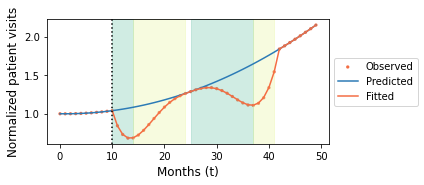

In [21]:
print(df_data.columns)
df_data_new, df_para, resilience,adaptivity=quantification_model(df_data, t_start,duration,t_disruption_dict)

print(resilience,adaptivity)
time_series_data_plot(df_data_new,df_para,'time_step','#ofrecord',t_start,duration,False)


# Section 2. Figures 
1. Temporal (Monthly) visists figure

In [8]:
def time_series_data_plot(df,df_para,strx,stry,t_start,duration,show_surpass):
    
    fig, ax=plt.subplots(1,1, figsize=(6,2.5))
        
    ax.scatter(df[strx],df[stry],s=10,color='#f46d43',linestyle=':',linewidth=0.2,label='Observed')
    ax.plot(df[strx],df['#ofrecord_predict'],color='#2c7bb6',label='Predicted')
    ax.plot(df[strx][t_start:duration],df['MOP'][t_start:duration],color='#f46d43',label='Fitted')


    for key,row in df_para.iterrows():
        amplitude=row['a']
        t_start=row['t_start']
        t_end=row['t_end']
        t_absorb=row['t_absorb']
        
        if key==0:
            ax.axvline(x=t_start,color='black',linestyle=':')
        if amplitude>0:
            if t_end>=duration:
                t_end=duration
            if t_absorb>=t_end:
                t_absorb=t_end
            ax.axvspan(t_start,t_absorb,alpha=0.3,color='#66c2a5')
            ax.axvspan(t_absorb,t_end,alpha=0.3,color='#e6f598')
        if show_surpass==True:
            if amplitude<0:
                t_absorb=row['t_absorb']
                if t_end>duration:
                    t_end=duration
                if t_absorb>=t_end:
                    t_absorb=t_end
                ax.fill_between(df[strx],df['#ofrecord_predict'], df['MOP'],
                 where = (df[strx] >= t_start) & (df[strx] <= t_end),
                 color = 'grey',label='surpass')
    ax.set_ylabel('Normalized patient visits',fontsize=12)
    ax.set_xlabel('Months (t)',fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()
    fig.savefig('time_series_data_plot.png',dpi=600)